In [1]:
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from utils.data import load_pickle
from utils.beam_search import BeamSearch

In [2]:
def adj_matrix_to_list(adj_matrix):
    adj_list = []
    
    for i, row in enumerate(adj_matrix):
        dest = np.argwhere(row>0).flatten()
        src = np.full(dest.size, i)
        
        adj_list.extend(zip(src, dest))
    
    return adj_list

def plot_edge_predictions(coords, pred, target):
    G = nx.from_numpy_array(target)
    pos = dict(enumerate(coords))
    
    pred_edge_list = adj_matrix_to_list(pred)

    nx.draw_networkx(G, pos)
    nx.draw_networkx_edges(G, pos, edgelist=pred_edge_list, edge_color='red', alpha=0.1, width=3)
    
    plt.show()

In [3]:
features, targets, preds = load_pickle("data/preds.pkl")

In [4]:
y_preds = preds[..., 1]
y_preds.shape

torch.Size([64, 20, 20])

In [5]:
coords, demands, dist_mat = features[0], features[1], features[2]

In [6]:
beam_width = 1024
num_vehicles = 3

In [88]:
def beam_search_most_probable_tour(y_preds, beam_width, num_vehicles):
    bs = BeamSearch(y_preds, beam_width=beam_width, num_vehicles=num_vehicles)
    bs.search()
    
    # get most probable beams
    beams = bs.get_beam(0)
    
    return beams

def beam_search_shortest_valid_tour(y_preds, dist_mats, demands, max_capacity,
                                    beam_width, num_vehicles):
    bs = BeamSearch(y_preds, beam_width=beam_width, num_vehicles=num_vehicles)
    bs.search()
    
    shortest_tour_length = np.full(y_preds.shape[0], np.inf)
    shortest_valid_tours = {}
    
    # TODO: optimize this function - it takes too long to run
    for b in range(beam_width):
        beams = bs.get_beam(b)
        
        for i, beam in enumerate(beams):
            tour_length = tour_length_from_tour_list(beam, dist_mats[i])
            is_valid = is_valid_capacity_tour(beam, demands[i], max_capacity)
            
            if tour_length < shortest_tour_length[i] and is_valid:
                shortest_tour_length[i] = tour_length
                shortest_valid_tours[i] = beam
                
                
    return shortest_valid_tours

In [87]:
tours = beam_search_most_probable_tour(y_preds, beam_width, num_vehicles)

In [90]:
%%time
shortest_valid = beam_search_shortest_valid_tour(y_preds, dist_mat, demands, 40, beam_width, num_vehicles)

CPU times: user 29.8 s, sys: 236 ms, total: 30 s
Wall time: 28.8 s


In [91]:
shortest_valid

{19: tensor([ 0,  3, 13,  9, 12,  7,  0, 19, 17, 11, 18,  1,  2,  8,  0,  6, 10, 15,
          5, 14, 16,  4]),
 26: tensor([ 0, 17,  6,  8,  4,  2,  3,  0, 12, 16,  9, 14,  0, 10, 15, 11,  7, 19,
         13,  1, 18,  5]),
 48: tensor([ 0,  2,  4,  1, 15, 12, 14,  0,  9, 11,  5,  3,  6, 17, 18, 13,  0,  8,
         16, 19,  7, 10]),
 50: tensor([ 0, 13,  4,  1,  6, 14, 12, 19,  0, 18,  3,  7, 10, 17, 15,  0,  9,  5,
          8,  2, 16, 11]),
 49: tensor([ 0, 10,  9,  8,  0, 17,  3, 13,  5,  6,  1,  2,  0, 19,  4, 18, 14, 16,
         15, 11, 12,  7]),
 16: tensor([ 0,  3, 15,  4,  5,  9,  1,  6,  0,  2, 19, 18, 16, 11, 17,  0,  8, 14,
         10,  7, 12, 13]),
 3: tensor([ 0, 16,  0, 12,  2, 13, 10,  7, 15,  9,  1,  3,  4,  0,  6,  5, 17, 14,
         11, 18,  8, 19]),
 9: tensor([ 0, 13, 10, 17, 14, 12, 18,  0, 15, 19,  3,  1,  5,  4, 11,  8,  0,  6,
          9,  7, 16,  2]),
 7: tensor([ 0, 12,  2, 18,  0,  8, 15,  3, 19,  7, 11,  5,  1,  0, 14,  4,  6, 17,
         10,  9, 16, 1

In [55]:
def tour_length_from_adj_matrix(adj_mat, dist_mat):
    return np.sum(adj_mat * dist_mat, axis=-1).sum(axis=-1) / 2

def tour_length_from_tour_list(tour, dist_mat):
    total = 0
    
    for i in range(len(tour)):
        j = (i + 1) % len(tour)
        xi = tour[i]
        xj = tour[j]
        
        total += dist_mat[xi][xj]
        
    return total

def is_valid_capacity_tour(tour, demand, max_capacity):
    running_total = 0
    for idx in tour:
        if idx == 0:
            running_total = 0
        else:
            running_total += demand[idx]
        
        if running_total > max_capacity:
            return False
    
    return True

def mean_tour_length(tours, dist_mats):
    total = 0
    
    for i, tour in enumerate(tours):
        total += tour_length_from_tour_list(tour, dist_mats[i])
        
    return total / len(tours)

def get_valid_tours(tours, demands, max_capacity):
    valid_count = 0
    valid_tour_idx = []
    
    for i, tour in enumerate(tours):
        is_valid = is_valid_capacity_tour(tour, demands[i], max_capacity)
        if is_valid:
            valid_count += 1
            valid_tour_idx.append(i)
            
    return valid_count, valid_tour_idx

def optimality_gap(pred_tour_length, actual_tour_length):
    return pred_tour_length / actual_tour_length - 1

In [26]:
mean_tour_length(tours.numpy(), dist_mat.numpy())

4.513701047668292

In [72]:
get_valid_tours(tours.numpy(), demands.numpy(), 40)

(4, [19, 26, 48, 50])

In [73]:
tour_length_from_adj_matrix(targets[10].numpy(), dist_mat[10].numpy())

4.312058657407761

In [74]:
tour_length_from_tour_list(tours[10].cpu().numpy(), dist_mat[10].cpu().numpy())

3.859757337719202

In [75]:
is_valid_capacity_tour(tours[10].numpy(), demands[10].numpy(), 40)

False

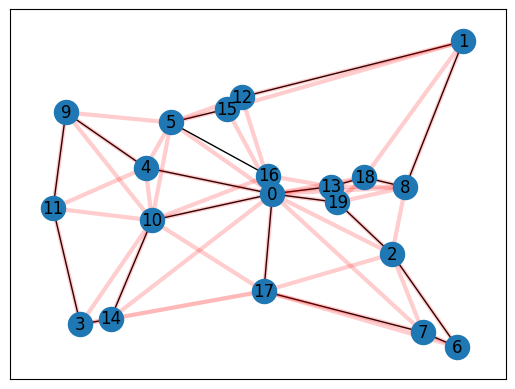

In [43]:
idx = 10

coords_np = coords.cpu().numpy()
preds_np = preds.argmax(dim=3).cpu().numpy()
targets_np = targets.cpu().numpy()

plot_edge_predictions(coords_np[idx], preds_np[idx], targets_np[idx])